<a href="https://colab.research.google.com/github/anuragbantu/DL-Assignment-1/blob/main/Assignment-1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#import the required libraries

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
from keras.datasets import fashion_mnist

# **Question 1**

The fashion_MNIST dataset is loaded and 1 sample image for each classs is plotted below.

In [2]:
(x_train, y_train), (x_test, y_test) = fashion_mnist.load_data()


29515/29515 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
26421880/26421880 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
5148/5148 ━━━━━━━━━━━━━━━━━━━━ 0s 1us/step
4422102/4422102 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [3]:
#installing wandb and then logging in
!pip install wandb -Uq

In [4]:
import wandb
wandb.login()

wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter:

 ··········


wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: ma24m003 (ma24m003-iit-madras) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


True

In [5]:
class_labels = {
    0: 'T-shirt/top',
    1: 'Trouser',
    2: 'Pullover',
    3: 'Dress',
    4: 'Coat',
    5: 'Sandal',
    6: 'Shirt',
    7: 'Sneaker',
    8: 'Bag',
    9: 'Ankle boot'
}

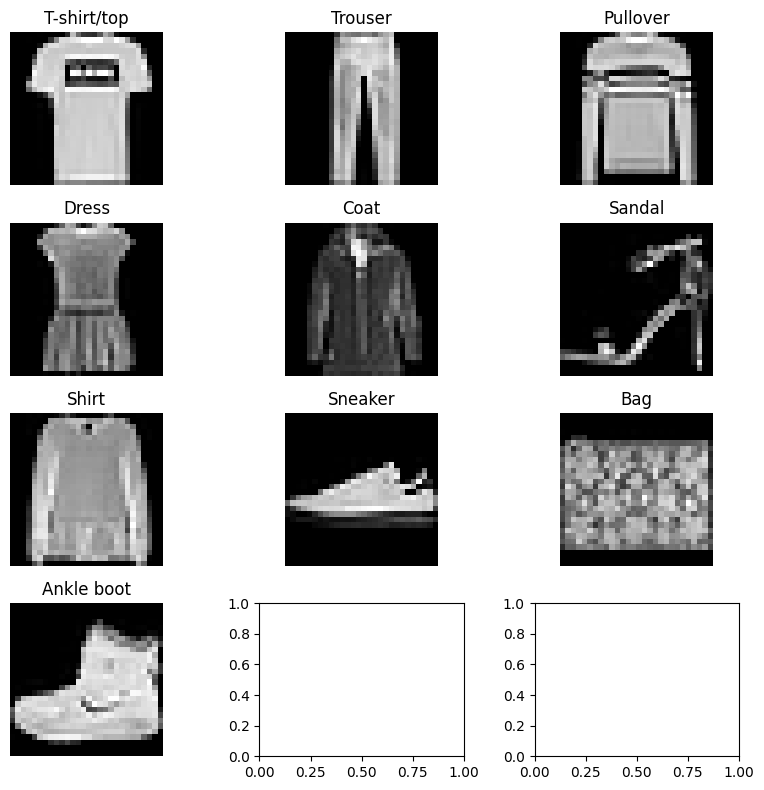

In [6]:
wandb.init(project="fashion-mnist-visualization")

fig, axes = plt.subplots(4, 3, figsize=(8, 8))

for i in range(10):
    idx = np.where(y_train == i)[0][0]
    ax = axes[i // 3, i % 3]
    ax.imshow(x_train[idx], cmap='gray')
    ax.set_title(class_labels[i])
    ax.axis('off')

plt.tight_layout()

wandb.log({"Fashion MNIST Samples": wandb.Image(fig)})

plt.show()

wandb.finish()

## **Question 2 & 3**

preparing the dataset.

In [7]:
x_train = x_train.reshape(x_train.shape[0], 28, 28, 1)
x_train = x_train.astype('float32') / 255.0

In [8]:
def one_hot_encode(labels, num_classes=None):
    if num_classes is None:
        num_classes = np.max(labels) + 1

    encoded = np.zeros((len(labels), num_classes))

    encoded[np.arange(len(labels)), labels] = 1

    return encoded

y_train = one_hot_encode(y_train)


In [9]:
y_test = one_hot_encode(y_test)

Define all the activation functions and the necessary loss functions. We will use cross entropy loss for the most part but in Question 8 we will use squared error loss as well.

In [10]:
def sigmoid(x):
  return 0.5 * (1 + np.tanh(0.5 * x))

def sigmoid_d(x):
  s= sigmoid(x)
  return s*(1-s)

def softmax(x):
    e_x = np.exp(x - np.max(x, axis=-1, keepdims=True) + 1e-8)
    return e_x / np.sum(e_x, axis=-1, keepdims=True)

def softmax_d(x):
    diag_s = np.diag(x)

    outer_s = np.outer(x, x)
    return diag_s - outer_s

def tanh(x):
    return np.tanh(x)

def tanh_d(x):
    return 1 - np.square(np.tanh(x))

def relu(x):
    return np.maximum(0, x)

def relu_d(x):
    return np.where(x > 0, 1, 0)

#CCE loss function
def categorical_cross_entropy(y_true, y_pred, layers, weight_decay=0):
    epsilon = 1e-15
    y_pred = np.clip(y_pred, epsilon, 1 - epsilon)
    loss = -np.sum(y_true * np.log(y_pred), axis=-1)
    loss = np.mean(loss)

    l2_penalty = weight_decay * sum(np.sum(layer.weights ** 2) for layer in layers)

    return loss + l2_penalty

#MSE loss
def squared_error_loss(y_true, y_pred):
    return (np.mean(np.sum((y_true - y_pred) ** 2, axis=1))/2)

activations = {"sigmoid":sigmoid,"softmax":softmax,"tanh":tanh,"relu":relu}

derivatives = {"sigmoid":sigmoid_d}





Define a class for layers.

In [11]:
class layer:
  def __init__(self, input, neurons, activation, weight_init):
    if weight_init == "xavier":
        self.weights = np.random.randn(input, neurons) * np.sqrt(1 / input)
    else:
        self.weights = np.random.randn(input, neurons)
    self.bias = np.zeros((1, neurons))
    self.activation = activations[activation]
    self.activation_d = derivatives.get(activation, None)

  #define forward propagation
  def forward(self, a_prev):
    self.a_prev = a_prev
    self.z = np.dot(self.a_prev,self.weights) + self.bias
    self.a = self.activation(self.z)
    return self.a

  #define all the optimization techniques being used
  def sgd(self,w_d,b_d,lr):
    self.weights -= lr*w_d
    self.bias -= lr*b_d

  def momentum_gd(self, w_d, b_d, lr, momentum=0.9):
    if not hasattr(self, 'm_w'):
        self.m_w = np.zeros_like(self.weights)
    if not hasattr(self, 'm_b'):
        self.m_b = np.zeros_like(self.bias)
    self.m_w = momentum * self.m_w + lr * w_d
    self.m_b = momentum * self.m_b + lr * b_d
    self.weights -= self.m_w
    self.bias -= self.m_b

  def nesterov_gd(self, w_d, b_d, lr, momentum=0.9):
      if not hasattr(self, 'm_w'):
          self.m_w = np.zeros_like(self.weights)
      if not hasattr(self, 'm_b'):
          self.m_b = np.zeros_like(self.bias)
      m_w_prev, m_b_prev = self.m_w, self.m_b
      self.m_w = momentum * self.m_w + lr * w_d
      self.m_b = momentum * self.m_b + lr * b_d
      self.weights -= momentum * m_w_prev + (1 + momentum) * self.m_w
      self.bias -= momentum * m_b_prev + (1 + momentum) * self.m_b

  def rmsprop(self, w_d, b_d, lr, decay_rate=0.9, epsilon=1e-8):
      if not hasattr(self, 'v_w'):
          self.v_w = np.zeros_like(self.weights)
      if not hasattr(self, 'v_b'):
          self.v_b = np.zeros_like(self.bias)
      self.v_w = decay_rate * self.v_w + (1 - decay_rate) * np.square(w_d)
      self.v_b = decay_rate * self.v_b + (1 - decay_rate) * np.square(b_d)
      self.weights -= lr * w_d / (np.sqrt(self.v_w) + epsilon)
      self.bias -= lr * b_d / (np.sqrt(self.v_b) + epsilon)

  def adam(self, w_d, b_d, lr, beta1=0.9, beta2=0.999, epsilon=1e-8):

      if not hasattr(self, 'm_w'):
        self.m_w = np.zeros_like(self.weights)
      if not hasattr(self, 'm_b'):
          self.m_b = np.zeros_like(self.bias)
      if not hasattr(self, 'v_w'):
          self.v_w = np.zeros_like(self.weights)
      if not hasattr(self, 'v_b'):
          self.v_b = np.zeros_like(self.bias)
      if not hasattr(self, 't'):
          self.t = 0

      self.t += 1

      self.m_w = beta1 * self.m_w + (1 - beta1) * w_d
      self.m_b = beta1 * self.m_b + (1 - beta1) * b_d
      self.v_w = beta2 * self.v_w + (1 - beta2) * np.square(w_d)
      self.v_b = beta2 * self.v_b + (1 - beta2) * np.square(b_d)
      m_w_hat = self.m_w / (1 - beta1**self.t)
      m_b_hat = self.m_b / (1 - beta1**self.t)
      v_w_hat = self.v_w / (1 - beta2**self.t)
      v_b_hat = self.v_b / (1 - beta2**self.t)
      self.weights -= lr * m_w_hat / (np.sqrt(v_w_hat) + epsilon)
      self.bias -= lr * m_b_hat / (np.sqrt(v_b_hat) + epsilon)

  def nadam(self, w_d, b_d, lr, beta1=0.9, beta2=0.999, epsilon=1e-8):
      if not hasattr(self, 'm_w'):
        self.m_w = np.zeros_like(self.weights)
      if not hasattr(self, 'm_b'):
          self.m_b = np.zeros_like(self.bias)
      if not hasattr(self, 'v_w'):
          self.v_w = np.zeros_like(self.weights)
      if not hasattr(self, 'v_b'):
          self.v_b = np.zeros_like(self.bias)
      if not hasattr(self, 't'):
          self.t = 0
      self.t += 1
      self.m_w = beta1 * self.m_w + (1 - beta1) * w_d
      self.m_b = beta1 * self.m_b + (1 - beta1) * b_d
      self.v_w = beta2 * self.v_w + (1 - beta2) * np.square(w_d)
      self.v_b = beta2 * self.v_b + (1 - beta2) * np.square(b_d)
      m_w_hat = self.m_w / (1 - beta1**self.t)
      m_b_hat = self.m_b / (1 - beta1**self.t)
      v_w_hat = self.v_w / (1 - beta2**self.t)
      v_b_hat = self.v_b / (1 - beta2**self.t)
      m_w_bar = beta1 * m_w_hat + ((1 - beta1) / (1 - beta1**self.t)) * w_d
      m_b_bar = beta1 * m_b_hat + ((1 - beta1) / (1 - beta1**self.t)) * b_d
      self.weights -= lr * m_w_bar / (np.sqrt(v_w_hat) + epsilon)
      self.bias -= lr * m_b_bar / (np.sqrt(v_b_hat) + epsilon)


  #define the backpropagation algorithm
  def backprop(self, a_d, lr, optimizer, weight_decay=0):
    if self.activation_d:
      z_d = np.multiply(self.activation_d(self.z),a_d)
    else:
      z_d = a_d

    w_d = np.dot(self.a_prev.T,z_d) + weight_decay * self.weights
    b_d = np.sum(z_d,axis=0,keepdims=True)
    a_prev_d = np.dot(z_d,self.weights.T)

    if optimizer == 'sgd':
            self.sgd(w_d, b_d, lr)
    elif optimizer == 'momentum':
        self.momentum_gd(w_d, b_d, lr)
    elif optimizer == 'nesterov':
        self.nesterov_gd(w_d, b_d, lr)
    elif optimizer == 'rmsprop':
        self.rmsprop(w_d, b_d, lr)
    elif optimizer == 'adam':
        self.adam(w_d, b_d, lr)
    elif optimizer == 'nadam':
        self.nadam(w_d, b_d, lr)
    else:
        raise ValueError(f"Unknown optimizer: {optimizer}")

    return a_prev_d



# Question 3

Implement backpropagation algorithm

# Question 4,5,6


Training different neural entwrok models while using wandb for hyperparamter tuning to find the best performing combinations.

In [12]:
#setting 10%of the training data aside for validation
from sklearn.model_selection import train_test_split

x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.1, random_state=0)

Setting up the strategy and different parameter values to be analyzed by wandb sweep experiments. Here, we use Bayesian optimization with the goal of maximizing validation accuracy.

In [13]:
#setting the sweep configuration for wandb
import numpy as np

sweep_config = {
    'method': 'bayes',
    'metric': {'name': 'val_accuracy', 'goal': 'maximize'},
    'parameters': {
        'epochs': {'values': [5, 10, 15]},
        'num_hidden_layers': {'values': [3, 4, 5]},
        'fc_layer_size': {'values': [32, 64, 128]},
        'weight_decay': {'values': [0, 0.0005,0.005,0.05, 0.5]},
        'lr': {'values': [1e-3, 1e-4,1e-5]},
        'optimizer': {'values': ['sgd', 'momentum', 'nesterov', 'rmsprop', 'adam', 'nadam']},
        'batch_size': {'values': [16, 32, 64]},
        'weight_init': {'values': ['random', 'xavier']},
        'activation': {'values': ['sigmoid', 'tanh', 'relu']}
    }
}

sweep_id = wandb.sweep(sweep_config, project="neural-network-hyperparam-tuning")

#defining accuracy metric to measure the model performance
def accuracy(y_true, y_pred):
    return np.mean(np.argmax(y_true, axis=1) == np.argmax(y_pred, axis=1))





Create sweep with ID: klzawh2p
Sweep URL: https://wandb.ai/ma24m003-iit-madras/neural-network-hyperparam-tuning/sweeps/klzawh2p


Now, we train the neural networks with different hyperparameter values on the training set. After each epoch, we analyze the performance of the model on the validation set and at the end after all the epochs of training the model we look at the performance on the test dataset. This wandb sweep is run with count=100 which will evaluate 100 different combinations of hyperparameters.

In [14]:
#train the neural network with categorical cross entropy loss

def train_network(config=None):
    with wandb.init(config=config, project="neural-network-hyperparam-tuning"):
        config = wandb.config

        #set the model name using all the parameter values
        run_name = (f"hl_{config['num_hidden_layers']}_bs_{config['batch_size']}_ac_{config['activation']}_"
            f"fc_{config['fc_layer_size']}_lr_{config['lr']}_opt_{config['optimizer']}_"
            f"wd_{config['weight_decay']}_wi_{config['weight_init']}_ep_{config['epochs']}")
        wandb.run.name = run_name

        #initialize the 1st input layer
        layers = [
            layer(784, config.fc_layer_size, config.activation, config.weight_init)
        ]


        #build the subsequent hidden layers and add the last outputlayer
        for _ in range(config.num_hidden_layers - 1):
            layers.append(layer(config.fc_layer_size, config.fc_layer_size, config.activation, config.weight_init))
        layers.append(layer(config.fc_layer_size, 10, "softmax", config.weight_init))

        num_samples = x_train.shape[0]

        #train over epochs
        for epoch in range(config.epochs):
            shuffled_indices = np.random.permutation(num_samples)
            x_train_shuffled = x_train[shuffled_indices]
            y_train_shuffled = y_train[shuffled_indices]

            epoch_loss = 0
            epoch_acc = 0

            #iterate over batches
            for start in range(0, num_samples, config.batch_size):
                end = min(start + config.batch_size, num_samples)
                x_batch = x_train_shuffled[start:end]
                y_batch = y_train_shuffled[start:end]

                #forward propagation
                a = x_batch
                for l in layers:
                    a = l.forward(a)

                #calculate loss and accuracy
                loss = categorical_cross_entropy(y_batch, a,layers, config.weight_decay)
                acc = accuracy(y_batch, a)

                epoch_loss += loss
                epoch_acc += acc

                #backward propagation
                a_d = a - y_batch
                for l in reversed(layers):
                    a_d = l.backprop(a_d, config.lr, config.optimizer, config.weight_decay)

            num_batches = max(1, num_samples // config.batch_size)
            avg_loss = epoch_loss / num_batches
            avg_acc = epoch_acc / num_batches

            #calculate the validation loss and accuracy for the epoch
            a_val = x_val
            for l in layers:
                a_val = l.forward(a_val)

            val_loss = categorical_cross_entropy(y_val, a_val, layers, config.weight_decay)
            val_acc = accuracy(y_val, a_val)

            print(f"Epoch {epoch + 1}, Loss: {avg_loss}, Accuracy: {avg_acc}, val_loss: {val_loss}, val_accuracy: {val_acc}")

            wandb.log({"epoch": epoch + 1, "loss": avg_loss, "accuracy": avg_acc,
                       "val_loss": val_loss, "val_accuracy": val_acc})

        #After training, evaluate the model on the test dataset
        a_test = x_test
        for l in layers:
            a_test = l.forward(a_test)

        test_loss = categorical_cross_entropy(y_test, a_test,layers, config.weight_decay)
        test_acc = accuracy(y_test, a_test)
        print(f"Test Loss: {test_loss}, Test Accuracy: {test_acc}")

        wandb.log({"test_loss": test_loss, "test_accuracy": test_acc})


        #plot the confusion matrices
        y_pred = np.argmax(a_test, axis=1)
        y_true = np.argmax(y_test, axis=1)
        cm = confusion_matrix(y_true, y_pred)

        plt.figure(figsize=(8, 6))
        sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=range(10), yticklabels=range(10))
        plt.xlabel("Predicted")
        plt.ylabel("True")
        plt.title("Confusion Matrix")

        wandb.log({"confusion_matrix": wandb.Image(plt)})
        plt.close()



x_train = x_train.reshape(x_train.shape[0], -1)
x_val = x_val.reshape(x_val.shape[0], -1)
x_test = x_test.reshape(x_test.shape[0], -1)

wandb.agent(sweep_id, train_network, count=5) #used count=100 for the main sweep

wandb.finish()


wandb: Agent Starting Run: ui9eqv5e with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 32
wandb: 	epochs: 15
wandb: 	fc_layer_size: 64
wandb: 	lr: 1e-05
wandb: 	num_hidden_layers: 4
wandb: 	optimizer: adam
wandb: 	weight_decay: 0.5
wandb: 	weight_init: xavier


Epoch 1, Loss: 119.63228727027517, Accuracy: 0.10036307053941909, val_loss: 104.36939633330229, val_accuracy: 0.09716666666666667
Epoch 2, Loss: 92.72926228323067, Accuracy: 0.10034454653230587, val_loss: 82.26552526061455, val_accuracy: 0.09716666666666667
Epoch 3, Loss: 73.94749410093362, Accuracy: 0.10040011855364553, val_loss: 66.34757102588948, val_accuracy: 0.09716666666666667
Epoch 4, Loss: 60.13740927242985, Accuracy: 0.10038159454653231, val_loss: 54.378571766658624, val_accuracy: 0.09716666666666667
Epoch 5, Loss: 49.56619158772756, Accuracy: 0.10097436277415531, val_loss: 45.05799652459135, val_accuracy: 0.09666666666666666
Epoch 6, Loss: 41.214284005793935, Accuracy: 0.09969620628334322, val_loss: 37.5781401653212, val_accuracy: 0.0995
Epoch 7, Loss: 34.451676887772685, Accuracy: 0.09852919383521043, val_loss: 31.484789231895462, val_accuracy: 0.09633333333333334
Epoch 8, Loss: 28.923744598348673, Accuracy: 0.10067797866034381, val_loss: 26.485894679729977, val_accuracy: 0.

accuracy,▇▇▇▇█▆▄▇▄▁▅▄▆▇▅
epoch,▁▁▂▃▃▃▄▅▅▅▆▇▇▇█
loss,█▆▅▄▄▃▃▂▂▂▁▁▁▁▁
test_accuracy,▁
test_loss,▁
val_accuracy,▃▃▃▃▂█▁▃▃▃▃▃▃▃▃
val_loss,█▆▅▄▄▃▃▂▂▂▁▁▁▁▁
accuracy,0.09944
epoch,15
loss,10.37129
test_accuracy,0.1


wandb: Agent Starting Run: 88g3sr6b with config:
wandb: 	activation: tanh
wandb: 	batch_size: 32
wandb: 	epochs: 5
wandb: 	fc_layer_size: 64
wandb: 	lr: 0.0001
wandb: 	num_hidden_layers: 4
wandb: 	optimizer: adam
wandb: 	weight_decay: 0.05
wandb: 	weight_init: random


Epoch 1, Loss: 3150.3099568294733, Accuracy: 0.2298273562537048, val_loss: 3150.292324883122, val_accuracy: 0.35983333333333334
Epoch 2, Loss: 3157.611712573876, Accuracy: 0.44153823355068167, val_loss: 3161.3293981962975, val_accuracy: 0.489
Epoch 3, Loss: 3168.28878535192, Accuracy: 0.5271376704208655, val_loss: 3171.75762837136, val_accuracy: 0.5435
Epoch 4, Loss: 3179.111820979293, Accuracy: 0.5564241256668643, val_loss: 3183.0849651257226, val_accuracy: 0.565
Epoch 5, Loss: 3191.5429132065296, Accuracy: 0.5703912270302312, val_loss: 3196.6279799519175, val_accuracy: 0.5616666666666666
Test Loss: 3196.7034484481505, Test Accuracy: 0.5619


accuracy,▁▅▇██
epoch,▁▃▅▆█
loss,▁▂▄▆█
test_accuracy,▁
test_loss,▁
val_accuracy,▁▅▇██
val_loss,▁▃▄▆█
accuracy,0.57039
epoch,5
loss,3191.54291
test_accuracy,0.5619


wandb: Agent Starting Run: x9a1lehe with config:
wandb: 	activation: tanh
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	fc_layer_size: 128
wandb: 	lr: 1e-05
wandb: 	num_hidden_layers: 5
wandb: 	optimizer: momentum
wandb: 	weight_decay: 0.005
wandb: 	weight_init: xavier


Epoch 1, Loss: 4.603485398295512, Accuracy: 0.6042902332937921, val_loss: 4.60457421741601, val_accuracy: 0.6908333333333333
Epoch 2, Loss: 4.968078334061702, Accuracy: 0.7260589659944643, val_loss: 5.420082403254692, val_accuracy: 0.7613333333333333
Epoch 3, Loss: 6.188123723048162, Accuracy: 0.7659895215500198, val_loss: 7.119690127903305, val_accuracy: 0.7751666666666667
Epoch 4, Loss: 8.343038868325555, Accuracy: 0.7854265519968368, val_loss: 9.761132157464406, val_accuracy: 0.7985
Epoch 5, Loss: 11.553906054062457, Accuracy: 0.7967205417160933, val_loss: 13.487306817126495, val_accuracy: 0.7911666666666667
Epoch 6, Loss: 15.625610663902865, Accuracy: 0.7967143633847371, val_loss: 18.201140222548105, val_accuracy: 0.7916666666666666
Epoch 7, Loss: 22.01708811187934, Accuracy: 0.7898255239224989, val_loss: 25.537263366086247, val_accuracy: 0.797
Epoch 8, Loss: 30.737145367544706, Accuracy: 0.7865324733096085, val_loss: 37.05745630496104, val_accuracy: 0.791
Epoch 9, Loss: 43.7113603

accuracy,▁▅▇███████
epoch,▁▂▃▃▄▅▆▆▇█
loss,▁▁▁▁▂▂▃▄▆█
test_accuracy,▁
test_loss,▁
val_accuracy,▁▆▆██████▇
val_loss,▁▁▁▂▂▂▃▄▆█
accuracy,0.7939
epoch,10
loss,59.37978
test_accuracy,0.7418


wandb: Agent Starting Run: 2sc5p2gs with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 16
wandb: 	epochs: 10
wandb: 	fc_layer_size: 32
wandb: 	lr: 0.001
wandb: 	num_hidden_layers: 3
wandb: 	optimizer: rmsprop
wandb: 	weight_decay: 0.05
wandb: 	weight_init: xavier


Epoch 1, Loss: 9.498775895832146, Accuracy: 0.5052962962962962, val_loss: 11.587957582425847, val_accuracy: 0.6196666666666667
Epoch 2, Loss: 12.290151661479435, Accuracy: 0.664074074074074, val_loss: 12.803261663249806, val_accuracy: 0.6926666666666667
Epoch 3, Loss: 13.096500856633847, Accuracy: 0.6949814814814815, val_loss: 13.301661830229307, val_accuracy: 0.721
Epoch 4, Loss: 13.672726442011093, Accuracy: 0.7203148148148149, val_loss: 14.10567430324474, val_accuracy: 0.7493333333333333
Epoch 5, Loss: 14.374886307811808, Accuracy: 0.7474814814814815, val_loss: 14.470137495572438, val_accuracy: 0.7405
Epoch 6, Loss: 14.577364635473431, Accuracy: 0.7571111111111111, val_loss: 14.578090379335883, val_accuracy: 0.7645
Epoch 7, Loss: 14.620098716637544, Accuracy: 0.7605925925925926, val_loss: 14.597236542917194, val_accuracy: 0.771
Epoch 8, Loss: 14.672979930627704, Accuracy: 0.7633148148148148, val_loss: 14.717088127597801, val_accuracy: 0.7706666666666667
Epoch 9, Loss: 14.70686970141

accuracy,▁▅▆▇██████
epoch,▁▂▃▃▄▅▆▆▇█
loss,▁▅▆▇██████
test_accuracy,▁
test_loss,▁
val_accuracy,▁▄▆▇▆███▇█
val_loss,▁▄▅▇▇█████
accuracy,0.76515
epoch,10
loss,14.7126
test_accuracy,0.6998


wandb: Agent Starting Run: cwit711o with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 32
wandb: 	epochs: 15
wandb: 	fc_layer_size: 128
wandb: 	lr: 0.0001
wandb: 	num_hidden_layers: 5
wandb: 	optimizer: sgd
wandb: 	weight_decay: 0.005
wandb: 	weight_init: random


Epoch 1, Loss: 835.9443424725428, Accuracy: 0.3352660047421458, val_loss: 833.8896844847169, val_accuracy: 0.4666666666666667
Epoch 2, Loss: 833.4729204014974, Accuracy: 0.5211914641375223, val_loss: 832.1399263166542, val_accuracy: 0.5585
Epoch 3, Loss: 831.8225733069208, Accuracy: 0.5897302904564315, val_loss: 830.5652297703155, val_accuracy: 0.6038333333333333
Epoch 4, Loss: 830.2812595035499, Accuracy: 0.6297236218138708, val_loss: 829.0540049758987, val_accuracy: 0.6368333333333334
Epoch 5, Loss: 828.787726633303, Accuracy: 0.6550459395376408, val_loss: 827.578031664146, val_accuracy: 0.6575
Epoch 6, Loss: 827.3209787451772, Accuracy: 0.6722362181387078, val_loss: 826.1202312149649, val_accuracy: 0.6728333333333333
Epoch 7, Loss: 825.8714785464217, Accuracy: 0.6847954949614701, val_loss: 824.6765417938878, val_accuracy: 0.6868333333333333
Epoch 8, Loss: 824.4342538601683, Accuracy: 0.6965211914641375, val_loss: 823.2450200068878, val_accuracy: 0.6948333333333333
Epoch 9, Loss: 823

accuracy,▁▄▅▆▇▇▇▇▇██████
epoch,▁▁▂▃▃▃▄▅▅▅▆▇▇▇█
loss,█▇▇▆▆▅▅▄▄▃▃▂▂▁▁
test_accuracy,▁
test_loss,▁
val_accuracy,▁▃▅▆▆▆▇▇▇▇█████
val_loss,█▇▇▆▆▅▅▄▄▃▃▂▂▁▁
accuracy,0.73803
epoch,15
loss,814.56326
test_accuracy,0.6878


# Question 7

We manually observe the best performing model from the sweep analysis charts based on maximizing test accuracy and evaluate the model again looking at the resulting confusing matrix of the model predictions.

Epoch 1, Loss: 1.4887554224128958, Accuracy: 0.7765555555555556
Epoch 2, Loss: 1.867773518647874, Accuracy: 0.8581481481481481
Epoch 3, Loss: 2.304144266454927, Accuracy: 0.8730185185185185
Epoch 4, Loss: 2.7549171190602975, Accuracy: 0.8818518518518519
Epoch 5, Loss: 3.2050828918927343, Accuracy: 0.8867592592592592
Epoch 6, Loss: 3.659059065817729, Accuracy: 0.8923148148148148
Epoch 7, Loss: 4.12908484481749, Accuracy: 0.8970925925925926
Epoch 8, Loss: 4.603696801543571, Accuracy: 0.8999259259259259
Epoch 9, Loss: 5.073681395103283, Accuracy: 0.9032777777777777
Epoch 10, Loss: 5.542024293617983, Accuracy: 0.9054629629629629
Epoch 11, Loss: 6.008048526017075, Accuracy: 0.9110555555555555
Epoch 12, Loss: 6.470205177050138, Accuracy: 0.9128888888888889
Epoch 13, Loss: 6.920839098789936, Accuracy: 0.9167962962962963
Epoch 14, Loss: 7.396275809734909, Accuracy: 0.9180555555555555
Epoch 15, Loss: 7.878106740690808, Accuracy: 0.919425925925926
Test Loss: 8.346778322017725, Test Accuracy: 0.8

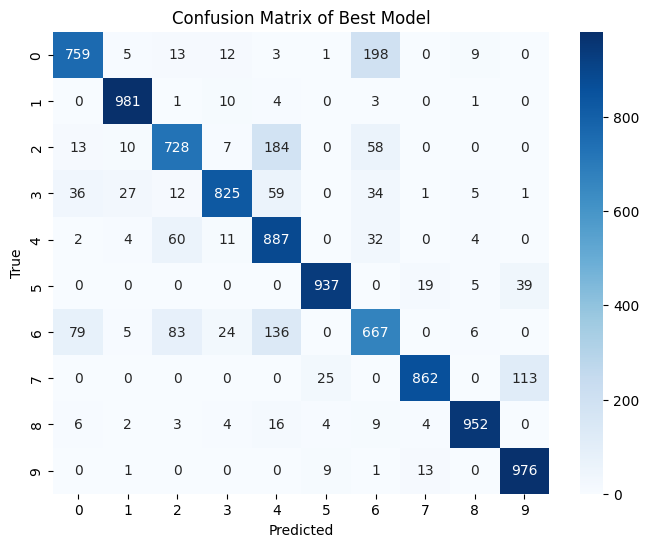

accuracy,▁▅▆▆▆▇▇▇▇▇█████
epoch,▁▁▂▃▃▃▄▅▅▅▆▇▇▇█
loss,▁▁▂▂▃▃▄▄▅▅▆▆▇▇█
test_accuracy,▁
test_loss,▁
accuracy,0.91943
epoch,15
loss,7.87811
test_accuracy,0.8574
test_loss,8.34678


In [15]:
#best model for cross entropy


wandb.init(project="neural-network-hyperparam-tuning", name="best_model_evaluation_0")

#set the identified best configuration
best_config = {
    "activation": "sigmoid",
    "batch_size": 16,
    "epochs": 15,
    "fc_layer_size": 128,
    "lr": 0.001,
    "num_hidden_layers": 3,
    "optimizer": "nadam",
    "weight_decay": 0.0005,
    "weight_init": "xavier"
}

#buil the neural network
layers = [
    layer(784, best_config["fc_layer_size"], best_config["activation"], best_config["weight_init"])
]
for _ in range(best_config["num_hidden_layers"] - 1):
    layers.append(layer(best_config["fc_layer_size"], best_config["fc_layer_size"], best_config["activation"], best_config["weight_init"]))
layers.append(layer(best_config["fc_layer_size"], 10, "softmax", best_config["weight_init"]))

num_samples = x_train.shape[0]

#train over epochs
for epoch in range(best_config["epochs"]):
    shuffled_indices = np.random.permutation(num_samples)
    x_train_shuffled = x_train[shuffled_indices]
    y_train_shuffled = y_train[shuffled_indices]

    epoch_loss = 0
    epoch_acc = 0
    #iterate over batches
    for start in range(0, num_samples, best_config["batch_size"]):
        end = min(start + best_config["batch_size"], num_samples)
        x_batch = x_train_shuffled[start:end]
        y_batch = y_train_shuffled[start:end]

        #perform forward propagation
        a = x_batch
        for l in layers:
            a = l.forward(a)
        #calucate the loss and accuracy
        loss = categorical_cross_entropy(y_batch, a, layers, best_config["weight_decay"])
        acc = accuracy(y_batch, a)

        epoch_loss += loss
        epoch_acc += acc

        #perform backward propagation
        a_d = a - y_batch
        for l in reversed(layers):
            a_d = l.backprop(a_d, best_config["lr"], best_config["optimizer"])

    num_batches = max(1, num_samples // best_config["batch_size"])
    avg_loss = epoch_loss / num_batches
    avg_acc = epoch_acc / num_batches

    print(f"Epoch {epoch + 1}, Loss: {avg_loss}, Accuracy: {avg_acc}")

    wandb.log({"epoch": epoch + 1, "loss": avg_loss, "accuracy": avg_acc})


#analyze performance on the test data
a_test = x_test
for l in layers:
    a_test = l.forward(a_test)

test_loss = categorical_cross_entropy(y_test, a_test, layers, best_config["weight_decay"])
test_acc = accuracy(y_test, a_test)

print(f"Test Loss: {test_loss}, Test Accuracy: {test_acc}")

wandb.log({"test_loss": test_loss, "test_accuracy": test_acc})

#build a confusion matric
y_pred = np.argmax(a_test, axis=1)
y_true = np.argmax(y_test, axis=1)
cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=range(10), yticklabels=range(10))
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix of Best Model")

wandb.log({"confusion_matrix": wandb.Image(plt)})
plt.show()

wandb.finish()

# Question 8

Now, instead of using cross entropy loss, we will use the squared error loss function and perform a similar wandb sweep as before to identify the best models and the accuracies achieved with this loss function.

In [16]:
#with MSE loss function

#define new sweep
new_sweep_id = wandb.sweep(sweep_config, project="neural-network-hyperparam-tuning")


def train_network(config=None):
    with wandb.init(config=config, project="neural-network-hyperparam-tuning"):
        config = wandb.config
        run_name = f"hl_{config.num_hidden_layers}_bs_{config.batch_size}_ac_{config.activation}"
        wandb.run.name = run_name

        layers = [
            layer(784, config.fc_layer_size, config.activation, config.weight_init)
        ]

        for _ in range(config.num_hidden_layers - 1):
            layers.append(layer(config.fc_layer_size, config.fc_layer_size, config.activation, config.weight_init))
        layers.append(layer(config.fc_layer_size, 10, "softmax", config.weight_init))

        num_samples = x_train.shape[0]

        for epoch in range(config.epochs):
            shuffled_indices = np.random.permutation(num_samples)
            x_train_shuffled = x_train[shuffled_indices]
            y_train_shuffled = y_train[shuffled_indices]

            epoch_loss = 0
            epoch_acc = 0

            for start in range(0, num_samples, config.batch_size):
                end = min(start + config.batch_size, num_samples)
                x_batch = x_train_shuffled[start:end]
                y_batch = y_train_shuffled[start:end]

                a = x_batch
                for l in layers:
                    a = l.forward(a)

                loss = squared_error_loss(y_batch, a)
                acc = accuracy(y_batch, a)

                epoch_loss += loss
                epoch_acc += acc

                a_d = (a - y_batch) * a * (1 - a)   #derivative of MSE loss with softmax output layer
                for l in reversed(layers):
                    a_d = l.backprop(a_d, config.lr, config.optimizer)

            num_batches = max(1, num_samples // config.batch_size)
            avg_loss = epoch_loss / num_batches
            avg_acc = epoch_acc / num_batches

            a_val = x_val
            for l in layers:
                a_val = l.forward(a_val)

            val_loss = squared_error_loss(y_val, a_val)
            val_acc = accuracy(y_val, a_val)

            print(f"Epoch {epoch + 1}, Loss: {avg_loss}, Accuracy: {avg_acc}, val_loss: {val_loss}, val_accuracy: {val_acc}")

            wandb.log({"epoch": epoch + 1, "loss": avg_loss, "accuracy": avg_acc,
                       "val_loss": val_loss, "val_accuracy": val_acc})

        a_test = x_test
        for l in layers:
            a_test = l.forward(a_test)

        test_loss = squared_error_loss(y_test, a_test)
        test_acc = accuracy(y_test, a_test)
        print(f"Test Loss: {test_loss}, Test Accuracy: {test_acc}")

        wandb.log({"test_loss": test_loss, "test_accuracy": test_acc})

        y_pred = np.argmax(a_test, axis=1)
        y_true = np.argmax(y_test, axis=1)
        cm = confusion_matrix(y_true, y_pred)

        plt.figure(figsize=(8, 6))
        sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=range(10), yticklabels=range(10))
        plt.xlabel("Predicted")
        plt.ylabel("True")
        plt.title("Confusion Matrix")

        wandb.log({"confusion_matrix": wandb.Image(plt)})
        plt.close()



x_train = x_train.reshape(x_train.shape[0], -1)
x_val = x_val.reshape(x_val.shape[0], -1)
x_test = x_test.reshape(x_test.shape[0], -1)

wandb.agent(new_sweep_id, train_network, count=5) #used count = 50 for the main sweep

wandb.finish()


Create sweep with ID: nn1fswes
Sweep URL: https://wandb.ai/ma24m003-iit-madras/neural-network-hyperparam-tuning/sweeps/nn1fswes


wandb: Agent Starting Run: th51pheh with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 16
wandb: 	epochs: 5
wandb: 	fc_layer_size: 128
wandb: 	lr: 0.0001
wandb: 	num_hidden_layers: 4
wandb: 	optimizer: rmsprop
wandb: 	weight_decay: 0.5
wandb: 	weight_init: random


Epoch 1, Loss: 0.3398662718125186, Accuracy: 0.48842592592592593, val_loss: 0.2194860340891802, val_accuracy: 0.6815
Epoch 2, Loss: 0.19470381837070666, Accuracy: 0.7197407407407408, val_loss: 0.18126309227877793, val_accuracy: 0.7405
Epoch 3, Loss: 0.16956516458451046, Accuracy: 0.7567777777777778, val_loss: 0.1674045975611306, val_accuracy: 0.7598333333333334
Epoch 4, Loss: 0.15663629980463664, Accuracy: 0.776425925925926, val_loss: 0.1583984867512088, val_accuracy: 0.769
Epoch 5, Loss: 0.14789848479472897, Accuracy: 0.7897037037037037, val_loss: 0.15122006000063443, val_accuracy: 0.7828333333333334
Test Loss: 0.17167075558811246, Test Accuracy: 0.7534


accuracy,▁▆▇██
epoch,▁▃▅▆█
loss,█▃▂▁▁
test_accuracy,▁
test_loss,▁
val_accuracy,▁▅▆▇█
val_loss,█▄▃▂▁
accuracy,0.7897
epoch,5
loss,0.1479
test_accuracy,0.7534


wandb: Agent Starting Run: sjuuhono with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 16
wandb: 	epochs: 15
wandb: 	fc_layer_size: 32
wandb: 	lr: 0.0001
wandb: 	num_hidden_layers: 4
wandb: 	optimizer: rmsprop
wandb: 	weight_decay: 0.005
wandb: 	weight_init: xavier


Epoch 1, Loss: 0.43432443136545856, Accuracy: 0.19181481481481483, val_loss: 0.4082151313964482, val_accuracy: 0.20066666666666666
Epoch 2, Loss: 0.39175176847522425, Accuracy: 0.294962962962963, val_loss: 0.37644499878687143, val_accuracy: 0.29433333333333334
Epoch 3, Loss: 0.3588188997384939, Accuracy: 0.4104259259259259, val_loss: 0.336668807232042, val_accuracy: 0.43966666666666665
Epoch 4, Loss: 0.30679084949926605, Accuracy: 0.5302037037037037, val_loss: 0.28576139303955045, val_accuracy: 0.5583333333333333
Epoch 5, Loss: 0.26755567237638705, Accuracy: 0.5707962962962962, val_loss: 0.25818262105533774, val_accuracy: 0.5805
Epoch 6, Loss: 0.24785713875341717, Accuracy: 0.6006481481481482, val_loss: 0.2441775101033348, val_accuracy: 0.6035
Epoch 7, Loss: 0.23460023377055045, Accuracy: 0.6259814814814815, val_loss: 0.23180076852068404, val_accuracy: 0.629
Epoch 8, Loss: 0.2229885623370669, Accuracy: 0.6427592592592593, val_loss: 0.22089008317916373, val_accuracy: 0.6471666666666667


accuracy,▁▂▄▅▅▆▆▆▇▇▇████
epoch,▁▁▂▃▃▃▄▅▅▅▆▇▇▇█
loss,█▇▆▅▄▃▃▃▂▂▂▂▁▁▁
test_accuracy,▁
test_loss,▁
val_accuracy,▁▂▄▅▆▆▆▆▇▇▇████
val_loss,█▇▆▅▄▃▃▃▂▂▂▁▁▁▁
accuracy,0.78235
epoch,15
loss,0.15725
test_accuracy,0.7467


wandb: Agent Starting Run: wa09qt1k with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 32
wandb: 	epochs: 5
wandb: 	fc_layer_size: 32
wandb: 	lr: 0.0001
wandb: 	num_hidden_layers: 5
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0.05
wandb: 	weight_init: xavier


Epoch 1, Loss: 0.4494510771048209, Accuracy: 0.1460617960877297, val_loss: 0.43926289198498225, val_accuracy: 0.18683333333333332
Epoch 2, Loss: 0.41470207442956325, Accuracy: 0.24223844101956135, val_loss: 0.3972755199772966, val_accuracy: 0.295
Epoch 3, Loss: 0.3851454638343265, Accuracy: 0.3234476882039123, val_loss: 0.37335611084115433, val_accuracy: 0.36816666666666664
Epoch 4, Loss: 0.36296107138393535, Accuracy: 0.389226437462952, val_loss: 0.3534622459593512, val_accuracy: 0.4231666666666667
Epoch 5, Loss: 0.3440791647244748, Accuracy: 0.4445205986959099, val_loss: 0.33615575981497176, val_accuracy: 0.4533333333333333
Test Loss: 0.33564256001553805, Test Accuracy: 0.4554


accuracy,▁▃▅▇█
epoch,▁▃▅▆█
loss,█▆▄▂▁
test_accuracy,▁
test_loss,▁
val_accuracy,▁▄▆▇█
val_loss,█▅▄▂▁
accuracy,0.44452
epoch,5
loss,0.34408
test_accuracy,0.4554


wandb: Agent Starting Run: 7qabiid1 with config:
wandb: 	activation: relu
wandb: 	batch_size: 16
wandb: 	epochs: 5
wandb: 	fc_layer_size: 128
wandb: 	lr: 0.0001
wandb: 	num_hidden_layers: 3
wandb: 	optimizer: nesterov
wandb: 	weight_decay: 0.005
wandb: 	weight_init: xavier


Epoch 1, Loss: 0.20141875283020147, Accuracy: 0.6968333333333333, val_loss: 0.13977756471365077, val_accuracy: 0.8043333333333333
Epoch 2, Loss: 0.1285947245851832, Accuracy: 0.8192222222222222, val_loss: 0.12099120466251254, val_accuracy: 0.8258333333333333
Epoch 3, Loss: 0.11666058381594306, Accuracy: 0.8362777777777778, val_loss: 0.11503565475061972, val_accuracy: 0.8376666666666667
Epoch 4, Loss: 0.11056908776900114, Accuracy: 0.845037037037037, val_loss: 0.10657495860150448, val_accuracy: 0.8533333333333334
Epoch 5, Loss: 0.10674852598081211, Accuracy: 0.8506851851851852, val_loss: 0.1125527483179975, val_accuracy: 0.846
Test Loss: 0.24437254056220536, Test Accuracy: 0.7549


accuracy,▁▇▇██
epoch,▁▃▅▆█
loss,█▃▂▁▁
test_accuracy,▁
test_loss,▁
val_accuracy,▁▄▆█▇
val_loss,█▄▃▁▂
accuracy,0.85069
epoch,5
loss,0.10675
test_accuracy,0.7549


wandb: Agent Starting Run: o02pxe2w with config:
wandb: 	activation: relu
wandb: 	batch_size: 32
wandb: 	epochs: 15
wandb: 	fc_layer_size: 64
wandb: 	lr: 1e-05
wandb: 	num_hidden_layers: 4
wandb: 	optimizer: nesterov
wandb: 	weight_decay: 0
wandb: 	weight_init: random


Epoch 1, Loss: 0.8988185685260075, Accuracy: 0.10173384706579727, val_loss: 0.8946666666666667, val_accuracy: 0.10533333333333333
Epoch 2, Loss: 0.9011373740367516, Accuracy: 0.09945539419087136, val_loss: 0.8946666666666667, val_accuracy: 0.10533333333333333
Epoch 3, Loss: 0.9011003260225252, Accuracy: 0.0994924422050978, val_loss: 0.8946666666666667, val_accuracy: 0.10533333333333333
Epoch 4, Loss: 0.9011558980438649, Accuracy: 0.09943687018375814, val_loss: 0.8946666666666667, val_accuracy: 0.10533333333333333
Epoch 5, Loss: 0.9011558980438649, Accuracy: 0.09943687018375814, val_loss: 0.8946666666666667, val_accuracy: 0.10533333333333333
Epoch 6, Loss: 0.9011003260225252, Accuracy: 0.0994924422050978, val_loss: 0.8946666666666667, val_accuracy: 0.10533333333333333
Epoch 7, Loss: 0.9011558980438649, Accuracy: 0.09943687018375814, val_loss: 0.8946666666666667, val_accuracy: 0.10533333333333333
Epoch 8, Loss: 0.9011373740367516, Accuracy: 0.09945539419087136, val_loss: 0.89466666666666

accuracy,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,▁▁▂▃▃▃▄▅▅▅▆▇▇▇█
loss,▁██████████████
test_accuracy,▁
test_loss,▁
val_accuracy,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
accuracy,0.09944
epoch,15
loss,0.90116
test_accuracy,0.1


As we did for cross entropy, we can analyze the best performing model for the squared error loss function.

Epoch 1, Loss: 0.23114668776170622, Accuracy: 0.6515482898378806
Epoch 2, Loss: 0.1479184453392856, Accuracy: 0.78883081257414
Epoch 3, Loss: 0.13018559410124173, Accuracy: 0.8157374456306841
Epoch 4, Loss: 0.12037224930609257, Accuracy: 0.8304295175958878
Epoch 5, Loss: 0.11418862353968709, Accuracy: 0.8389617931988927
Epoch 6, Loss: 0.10876786949498063, Accuracy: 0.8481922202451562
Epoch 7, Loss: 0.10437420497234146, Accuracy: 0.853202846975089
Epoch 8, Loss: 0.10074223427114593, Accuracy: 0.858405001977066
Epoch 9, Loss: 0.09745618813170327, Accuracy: 0.8632735270858047
Epoch 10, Loss: 0.09459316105778554, Accuracy: 0.8669434559114275
Test Loss: 0.12996372586724986, Test Accuracy: 0.8164


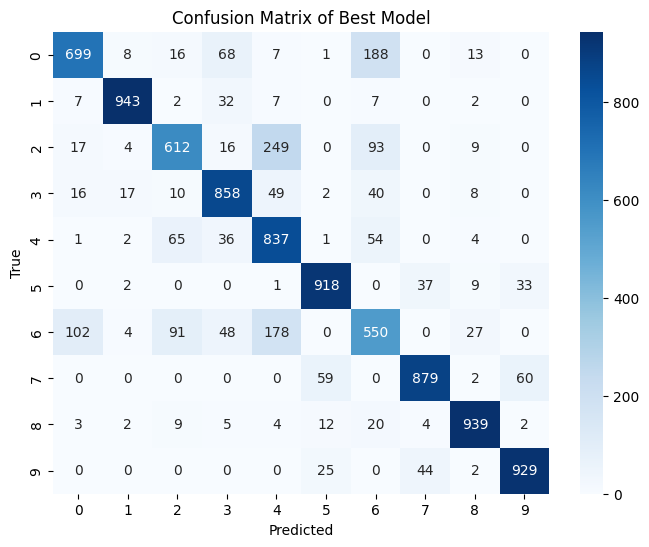

accuracy,▁▅▆▇▇▇████
epoch,▁▂▃▃▄▅▆▆▇█
loss,█▄▃▂▂▂▂▁▁▁
test_accuracy,▁
test_loss,▁
accuracy,0.86694
epoch,10
loss,0.09459
test_accuracy,0.8164
test_loss,0.12996


In [17]:
#best model for MSE loss function

wandb.init(project="neural-network-hyperparam-tuning", name="best_model_evaluation")

best_config = {
    "activation": "sigmoid",
    "batch_size": 64,
    "epochs": 10,
    "fc_layer_size": 64,
    "lr": 0.001,
    "num_hidden_layers": 4,
    "optimizer": "nadam",
    "weight_decay": 0.0005,
    "weight_init": "random"
}

layers = [
    layer(784, best_config["fc_layer_size"], best_config["activation"], best_config["weight_init"])
]
for _ in range(best_config["num_hidden_layers"] - 1):
    layers.append(layer(best_config["fc_layer_size"], best_config["fc_layer_size"], best_config["activation"], best_config["weight_init"]))
layers.append(layer(best_config["fc_layer_size"], 10, "softmax", best_config["weight_init"]))

num_samples = x_train.shape[0]

for epoch in range(best_config["epochs"]):
    shuffled_indices = np.random.permutation(num_samples)
    x_train_shuffled = x_train[shuffled_indices]
    y_train_shuffled = y_train[shuffled_indices]

    epoch_loss = 0
    epoch_acc = 0

    for start in range(0, num_samples, best_config["batch_size"]):
        end = min(start + best_config["batch_size"], num_samples)
        x_batch = x_train_shuffled[start:end]
        y_batch = y_train_shuffled[start:end]

        a = x_batch
        for l in layers:
            a = l.forward(a)

        loss = squared_error_loss(y_batch, a)
        acc = accuracy(y_batch, a)

        epoch_loss += loss
        epoch_acc += acc

        a_d = a - y_batch
        for l in reversed(layers):
            a_d = l.backprop(a_d, best_config["lr"], best_config["optimizer"])

    num_batches = max(1, num_samples // best_config["batch_size"])
    avg_loss = epoch_loss / num_batches
    avg_acc = epoch_acc / num_batches

    print(f"Epoch {epoch + 1}, Loss: {avg_loss}, Accuracy: {avg_acc}")

    wandb.log({"epoch": epoch + 1, "loss": avg_loss, "accuracy": avg_acc})


a_test = x_test
for l in layers:
    a_test = l.forward(a_test)

test_loss = squared_error_loss(y_test, a_test)
test_acc = accuracy(y_test, a_test)

print(f"Test Loss: {test_loss}, Test Accuracy: {test_acc}")

wandb.log({"test_loss": test_loss, "test_accuracy": test_acc})

y_pred = np.argmax(a_test, axis=1)
y_true = np.argmax(y_test, axis=1)
cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=range(10), yticklabels=range(10))
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix of Best Model")

wandb.log({"confusion_matrix": wandb.Image(plt)})
plt.show()

wandb.finish()

# Question 10

Based on our learnings from the experiments on the Fashion-MNIST dataset, we will take 3 of the best performing models and evaluate their performance on the MNIST dataset

In [18]:
from tensorflow.keras.datasets import mnist


In [19]:
(x_1_train, y_1_train), (x_1_test, y_1_test) = mnist.load_data()

x_1_train = x_1_train.reshape(x_1_train.shape[0], 28, 28, 1)
x_1_train = x_1_train.astype('float32') / 255.0

11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [20]:
y_1_train = one_hot_encode(y_1_train)
y_1_test = one_hot_encode(y_1_test)

In [21]:
x_train.shape

(54000, 784)

In [22]:
x_1_train.shape

(60000, 28, 28, 1)

In [23]:
rec_config_1 = {
    "activation": "sigmoid",
    "batch_size": 16,
    "epochs": 15,
    "fc_layer_size": 128,
    "lr": 0.001,
    "num_hidden_layers": 3,
    "optimizer": "nadam",
    "weight_decay": 0.005,
    "weight_init": "xavier"
}

layers = [layer(784, rec_config_1["fc_layer_size"], rec_config_1["activation"], rec_config_1["weight_init"])]
for _ in range(rec_config_1["num_hidden_layers"] - 1):
    layers.append(layer(rec_config_1["fc_layer_size"], rec_config_1["fc_layer_size"], rec_config_1["activation"], rec_config_1["weight_init"]))
layers.append(layer(rec_config_1["fc_layer_size"], 10, "softmax", rec_config_1["weight_init"]))

num_samples = x_1_train.shape[0]

x_1_train = x_1_train.reshape(x_1_train.shape[0], -1)
x_1_test = x_1_test.reshape(x_1_test.shape[0], -1)


for epoch in range(rec_config_1["epochs"]):
    shuffled_indices = np.random.permutation(num_samples)
    x_1_train_shuffled = x_1_train[shuffled_indices]
    y_1_train_shuffled = y_1_train[shuffled_indices]

    for start in range(0, num_samples, rec_config_1["batch_size"]):
        end = min(start + rec_config_1["batch_size"], num_samples)
        x_batch = x_1_train_shuffled[start:end]
        y_batch = y_1_train_shuffled[start:end]

        a = x_batch
        for l in layers:
            a = l.forward(a)

        loss = categorical_cross_entropy(y_batch, a, layers, rec_config_1["weight_decay"])

        a_d = a - y_batch
        for l in reversed(layers):
            a_d = l.backprop(a_d, rec_config_1["lr"], rec_config_1["optimizer"])

a_test = x_1_test
for l in layers:
    a_test = l.forward(a_test)

acc = accuracy(y_1_test, a_test)

print(f"Accuracy on x_1_test: {acc}")
print("Predictions on x_1_test:", y_pred)


Accuracy on x_1_test: 0.9645
Predictions on x_1_test: [9 2 1 ... 8 1 5]


In [24]:
rec_config_2 = {
    "activation": "sigmoid",
    "batch_size": 32,
    "epochs": 5,
    "fc_layer_size": 128,
    "lr": 0.001,
    "num_hidden_layers": 3,
    "optimizer": "adam",
    "weight_decay": 0.005,
    "weight_init": "xavier"
}

layers_2 = [layer(784, rec_config_2["fc_layer_size"], rec_config_2["activation"], rec_config_2["weight_init"])]
for _ in range(rec_config_2["num_hidden_layers"] - 1):
    layers_2.append(layer(rec_config_2["fc_layer_size"], rec_config_2["fc_layer_size"], rec_config_2["activation"], rec_config_2["weight_init"]))
layers_2.append(layer(rec_config_2["fc_layer_size"], 10, "softmax", rec_config_2["weight_init"]))

num_samples_2 = x_1_train.shape[0]

x_1_train = x_1_train.reshape(x_1_train.shape[0], -1)
x_1_test = x_1_test.reshape(x_1_test.shape[0], -1)

for epoch in range(rec_config_2["epochs"]):
    shuffled_indices = np.random.permutation(num_samples_2)
    x_1_train_shuffled = x_1_train[shuffled_indices]
    y_1_train_shuffled = y_1_train[shuffled_indices]

    for start in range(0, num_samples_2, rec_config_2["batch_size"]):
        end = min(start + rec_config_2["batch_size"], num_samples_2)
        x_batch = x_1_train_shuffled[start:end]
        y_batch = y_1_train_shuffled[start:end]

        a = x_batch
        for l in layers_2:
            a = l.forward(a)

        loss = categorical_cross_entropy(y_batch, a, layers_2, rec_config_2["weight_decay"])

        a_d = a - y_batch
        for l in reversed(layers_2):
            a_d = l.backprop(a_d, rec_config_2["lr"], rec_config_2["optimizer"])

a_test = x_1_test
for l in layers_2:
    a_test = l.forward(a_test)

acc = accuracy(y_1_test, a_test)

print(f"Accuracy on x_1_test for rec_config_2: {acc}")
print("Predictions on x_1_test for rec_config_2:", np.argmax(a_test, axis=1))


Accuracy on x_1_test for rec_config_2: 0.9612
Predictions on x_1_test for rec_config_2: [7 2 1 ... 4 5 6]


In [25]:
rec_config_3 = {
    "activation": "relu",
    "batch_size": 64,
    "epochs": 5,
    "fc_layer_size": 32,
    "lr": 0.001,
    "num_hidden_layers": 3,
    "optimizer": "adam",
    "weight_decay": 0.005,
    "weight_init": "xavier"
}

layers_3 = [layer(784, rec_config_3["fc_layer_size"], rec_config_3["activation"], rec_config_3["weight_init"])]
for _ in range(rec_config_3["num_hidden_layers"] - 1):
    layers_3.append(layer(rec_config_3["fc_layer_size"], rec_config_3["fc_layer_size"], rec_config_3["activation"], rec_config_3["weight_init"]))
layers_3.append(layer(rec_config_3["fc_layer_size"], 10, "softmax", rec_config_3["weight_init"]))

num_samples_3 = x_1_train.shape[0]

x_1_train = x_1_train.reshape(x_1_train.shape[0], -1)
x_1_test = x_1_test.reshape(x_1_test.shape[0], -1)

for epoch in range(rec_config_3["epochs"]):
    shuffled_indices = np.random.permutation(num_samples_3)
    x_1_train_shuffled = x_1_train[shuffled_indices]
    y_1_train_shuffled = y_1_train[shuffled_indices]

    for start in range(0, num_samples_3, rec_config_3["batch_size"]):
        end = min(start + rec_config_3["batch_size"], num_samples_3)
        x_batch = x_1_train_shuffled[start:end]
        y_batch = y_1_train_shuffled[start:end]

        a = x_batch
        for l in layers_3:
            a = l.forward(a)

        loss = categorical_cross_entropy(y_batch, a, layers_3, rec_config_3["weight_decay"])

        a_d = a - y_batch
        for l in reversed(layers_3):
            a_d = l.backprop(a_d, rec_config_3["lr"], rec_config_3["optimizer"])

a_test = x_1_test
for l in layers_3:
    a_test = l.forward(a_test)

acc = accuracy(y_1_test, a_test)

print(f"Accuracy on x_1_test for rec_config_3: {acc}")
print("Predictions on x_1_test for rec_config_3:", np.argmax(a_test, axis=1))


Accuracy on x_1_test for rec_config_3: 0.9161
Predictions on x_1_test for rec_config_3: [7 2 1 ... 4 5 6]
